In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
%matplotlib inline
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)

# --------------- Latex Plot Beautification --------------------------

/Users/austin/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [157]:
from matplotlib import collections  as mc
from load_rayfile import load_rayfile
import re

ray_dir = '/Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/rays/130f_60s/'

# Get files, frequencies:
d = os.listdir(ray_dir)

# -- Check which frequencies we have --
freqs_ray  = []
freqs_damp = []

p = re.compile("\d+")
for s in d:
    if s.endswith(".dat"):
        if s.startswith('newray'):
            tmp = p.findall(s)
            freqs_ray.append(int(tmp[0]))

        elif s.startswith('d'):
            tmp = p.findall(s)
            freqs_damp.append(int(tmp[0]))

freqs_ray.sort()
freqs_damp.sort()

# -- confirm we have the same damping and ray files: --
assert freqs_ray == freqs_damp, "mismatch between rayfiles and damping files!"


In [94]:
np.arange(0.5, 10, step=0.5)

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5])

In [158]:
# -- Load the ray files -- 
# ray_dir = '/Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/rays/RT4/'

lats = np.arange(0,80, step=0.5)
freqs_log = np.linspace(np.log10(200), np.log10(60000), 130)
freqs = np.round(pow(10, freqs_log))

nsteps = np.zeros([len(freqs),len(lats)])
tg_end = np.zeros([len(freqs),len(lats)])

for freq_ind, frequency in enumerate(freqs_ray):
    RF = load_rayfile(ray_dir, frequency)
    for lat_ind, lat in enumerate(lats):
        if RF.has_key(lat):
            nsteps[freq_ind, lat_ind] = np.shape(RF[lat])[0]
            if nsteps[freq_ind, lat_ind] > 0:
                tg_end[freq_ind, lat_ind] = RF[lat]['tg'].tail(1).values[0]


loading  /Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/rays/130f_60s/newray200.dat
loading  /Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/rays/130f_60s/newray209.dat
loading  /Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/rays/130f_60s/newray218.dat
loading  /Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/rays/130f_60s/newray228.dat
loading  /Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/rays/130f_60s/newray239.dat
loading  /Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/rays/130f_60s/newray249.dat
loading  /Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/rays/130f_60s/newray261.dat
loading  /Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/rays/130f_60s/newray273.dat
loading  /Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/rays/130f_60s/newray285.dat
loading  /Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/rays/130f_60s/newray298.dat
loading  /Users/austin/FUSE/shared/users/asousa/WIPP/WIPPv4/rays/130f_60s/newray311.dat
loading  /Users/austin/FUSE/shar

In [154]:
# -- Plot ray files --
def plot_rays(RF, l_min=0, l_max=90):
    
    all_lats = np.array(sorted(RF.keys()))
    lats = all_lats[(all_lats >= l_min) & (all_lats <= l_max)]
#     print all_lats

    
    L_shells = [1.5, 2, 3, 4, 5]


    # Initialize plot
    fig, ax = plt.subplots()

    # Plot the earth
    earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)

    # Plot the fieldlines
    for L in L_shells:
        lam = np.linspace(-80,80,181)
        L_r = L*pow(np.cos(lam*np.pi/180),2)
        Lx  = L_r*np.cos(lam*np.pi/180)
        Ly  = L_r*np.sin(lam*np.pi/180)
        plt.plot(Lx,Ly,color='r',linewidth=1,linestyle='dashed')  # Field line

    # Plot the rays
    for l in lats:    
        X = RF[l].distre*np.cos(RF[l].lat*np.pi/180.0)
        Y = RF[l].distre*np.sin(RF[l].lat*np.pi/180.0)
        # pick colormap here
        C = plt.cm.viridis(RF[l].power)
        points = np.array([X, Y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = mc.LineCollection(segments, colors=C,alpha=1,linewidth=3)
    #     lc.set_linewidth(10)

        ax.add_collection(lc)


    ax.add_patch(earth)                    # The earth (round)

    ax.autoscale()
#     ax.set_xlim([0, 5])
#     ax.set_ylim([-2, 2])
    ax.set_xlabel('L')
    ax.set_ylabel('L')



    plt.show()






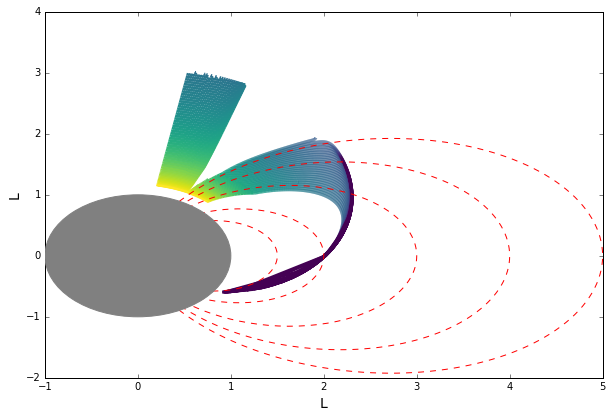

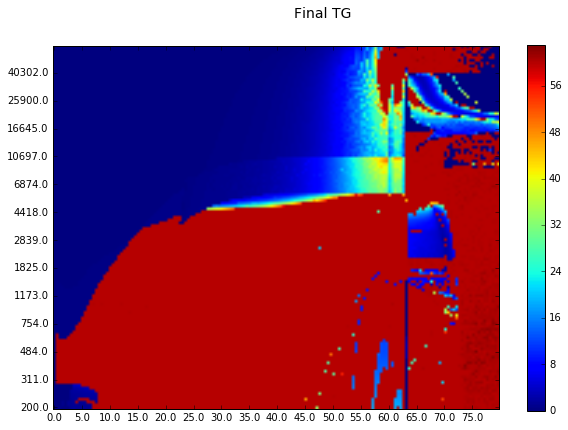

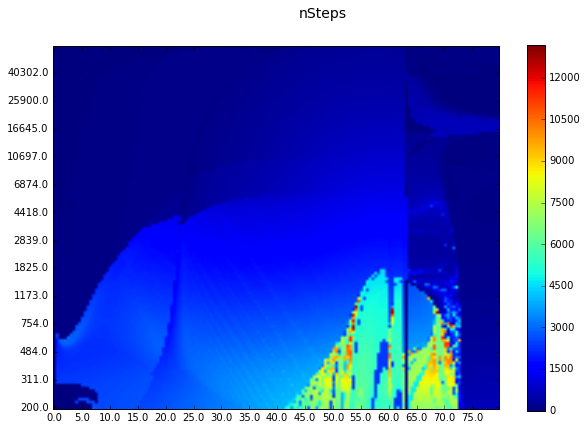

In [163]:
# Plot the lowest-latitude rays
plot_rays(RF,l_min=50, l_max=80)


fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
img = ax1.imshow(tg_end, origin='lower')

xtix = np.arange(0, len(lats), step=10)
ax1.set_xticks(xtix)
ax1.set_xticklabels(lats[xtix])

ytix = np.arange(0, len(freqs),step=10)
ax1.set_yticks(ytix)
ax1.set_yticklabels(freqs[ytix])

plt.colorbar(img)

fig.suptitle("Final TG")


fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
img2 = ax2.imshow(nsteps, origin='lower')

xtix = np.arange(0, len(lats), step=10)
ax2.set_xticks(xtix)
ax2.set_xticklabels(lats[xtix])

ytix = np.arange(0, len(freqs),step=10)
ax2.set_yticks(ytix)
ax2.set_yticklabels(freqs[ytix])

fig2.suptitle("nSteps")
plt.colorbar(img2)




In [180]:
tmpA = ['a','b','c']
tmpB = ['x','y','z']
tmpC = ['1','2','3']

# print zip(tmpA, tmpB, tmpC)

tmplist = [x for x in itertools.product(tmpA, tmpB, tmpC)]


(27, 3)
